# Baseline Model

Below we have the baseline model using an SVM network.

In [99]:
"""
Baseline Model - SVM
"""

import cv2
import numpy as np
import os

from sklearn import svm, metrics
from sklearn.model_selection import train_test_split

np.random.seed(0)
RANDOM_NUM = np.random.randint(1000)

In [31]:
DATA_PATH = "KLARR_NET_data/fer_2013"

IMG_WIDTH = 48
IMG_HEIGHT = 48

def create_dataset(img_folder):
    """ Creates a dataset of the images in the given folder and returns the
    data and labels array.
    """
    img_data_array = []
    class_name = []
   
    for class_num, dir in enumerate(os.listdir(img_folder)):
        print(f"Class Num: {class_num}, Directory: {dir}")

        for i, filename in enumerate(os.listdir(os.path.join(img_folder, dir))):
            if i % 1000 == 0:
                print(i)

            # Read the image in grayscale
            image_path = os.path.join(img_folder, dir, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(
                image,
                (IMG_HEIGHT, IMG_WIDTH),
                interpolation=cv2.INTER_AREA
            )

            # Convert to numpy and normalize between 0 and 1
            image = np.array(image).astype('float32').flatten() / 255

            img_data_array.append(image)
            class_name.append(class_num)

    return np.array(img_data_array), np.array(class_name)

X_train, y_train = create_dataset(DATA_PATH)
X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    train_size=0.7,
    random_state=RANDOM_NUM)

Class Num: 0, Directory: angry
0
1000
2000
3000
4000
Class Num: 1, Directory: fear
0
1000
2000
3000
4000
5000
Class Num: 2, Directory: happy
0
1000
2000
3000
4000
5000
Class Num: 3, Directory: neutral
0
1000
2000
3000
4000
5000
6000
Class Num: 4, Directory: sad
0
1000
2000
3000
4000
5000
6000
Class Num: 5, Directory: surprise
0
1000
2000
3000


In [32]:
CLASSES = ['angry', 'fear', 'happy' ,'neutral' ,'sad' ,'surprise']

def print_class_distribution_in_dataset(dataset_labels):
    num_classes = [0] * len(CLASSES)
    for label in dataset_labels:
        num_classes[label] += 1
    
    for i, num_of_class in enumerate(num_classes):
        print(f"Class: {CLASSES[i]}, Number of Classes: {num_of_class}")

print(f"Baseline Model Training Set Size: {len(X_train)}")
print_class_distribution_in_dataset(y_train)

print(f"\nBaseline Model Test Set Size: {len(X_test)}")
print_class_distribution_in_dataset(y_test)


Baseline Model Training Set Size: 22408
Class: angry, Number of Classes: 3467
Class: fear, Number of Classes: 3536
Class: happy, Number of Classes: 3958
Class: neutral, Number of Classes: 4365
Class: sad, Number of Classes: 4289
Class: surprise, Number of Classes: 2793

Baseline Model Test Set Size: 9604
Class: angry, Number of Classes: 1450
Class: fear, Number of Classes: 1545
Class: happy, Number of Classes: 1827
Class: neutral, Number of Classes: 1821
Class: sad, Number of Classes: 1773
Class: surprise, Number of Classes: 1188


In [33]:
# Instantiate the SVM classifier
# svm_classifier = svm.SVC(gamma=0.001)
svm_classifier = svm.SVC(
    kernel='linear',
    C=1,
    decision_function_shape='ovo',
)

# Fit to the training data
svm_classifier.fit(X_train, y_train)

SVC(C=1, decision_function_shape='ovo', kernel='linear')

In [36]:
y_pred = svm_classifier.predict(X_test)
classification_report = metrics.classification_report(y_test, y_pred)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

baseline_test_acc = svm_classifier.score(X_test, y_test)
print(f"Baseline Model Test Accuracy: {baseline_test_acc}")

print(f"Classification report for classifier {svm_classifier}:")
print(f"\n{classification_report}")

print(f"\nConfusion matrix:\n\n{confusion_matrix}")

Baseline Model Test Accuracy: 0.3263223656809663
Classification report for classifier SVC(C=1, decision_function_shape='ovo', kernel='linear'):

              precision    recall  f1-score   support

           0       0.23      0.25      0.24      1450
           1       0.25      0.24      0.24      1545
           2       0.40      0.39      0.40      1827
           3       0.33      0.36      0.35      1821
           4       0.29      0.29      0.29      1773
           5       0.49      0.43      0.46      1188

    accuracy                           0.33      9604
   macro avg       0.33      0.33      0.33      9604
weighted avg       0.33      0.33      0.33      9604


Confusion matrix:

[[359 217 250 276 266  82]
 [229 368 212 280 282 174]
 [279 217 720 262 264  85]
 [247 248 223 651 343 109]
 [321 239 268 334 522  89]
 [127 176 112 141 118 514]]


In [15]:
# # Save model parameters so we can load it later
from joblib import dump, load
from pathlib import Path

BASELINE_MODEL_LOCATION = f"models/{svm_classifier}"

Path("models").mkdir(parents=True, exist_ok=True)
dump(svm_classifier, BASELINE_MODEL_LOCATION)

# To load the model, uncomment this line
# clf = load(BASELINE_MODEL_LOCATION)

SVC(C=1, decision_function_shape='ovo', kernel='linear')


# CNN Implementation

In [1]:
"""
CNN model Implementation
"""

import matplotlib.pyplot as plt
import numpy as np
import os 
import torch

from torchvision import datasets, transforms

np.random.seed(0)
torch.manual_seed(1000)
RANDOM_NUM = np.random.randint(1000)

In [2]:
CLASSES = None

def print_class_distribution_in_dataset(dataset_labels):
    num_classes = [0] * len(CLASSES)
    for label in dataset_labels:
        num_classes[label] += 1
    
    for i, num_of_class in enumerate(num_classes):
        print(f"Class: {CLASSES[i]}, Number of Classes: {num_of_class}")

In [3]:
IMG_WIDTH = 48
IMG_HEIGHT = 48

DATA_PATH = "KLARR_NET_data/fer_2013"

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    ])

total_data = datasets.ImageFolder(root=DATA_PATH, transform=TRANSFORM_IMG)
total_data_len = len(total_data)
CLASSES = total_data.classes

print('Number of Images : ', total_data_len)
print_class_distribution_in_dataset(total_data.targets)

Number of Images :  32012
Class: angry, Number of Classes: 4917
Class: fear, Number of Classes: 5081
Class: happy, Number of Classes: 5785
Class: neutral, Number of Classes: 6186
Class: sad, Number of Classes: 6062
Class: surprise, Number of Classes: 3981


In [4]:
train_data_len = int(total_data_len * 0.7)
valid_data_len = int(total_data_len * 0.15)
test_data_len = total_data_len - train_data_len - valid_data_len

train_data, valid_data, test_data = torch.utils.data.random_split(
    total_data,
    (train_data_len, valid_data_len, test_data_len)
)

print(f"Number of Training Images: {len(train_data)}")
print_class_distribution_in_dataset([datapoint[1] for datapoint in train_data])

print(f"\nNumber of Validation Images: {len(valid_data)}")
print_class_distribution_in_dataset([datapoint[1] for datapoint in valid_data])

print(f"\nNumber of Test Images: {len(test_data)}")
print_class_distribution_in_dataset([datapoint[1] for datapoint in test_data])


Number of Training Images: 22408
Class: angry, Number of Classes: 3452
Class: fear, Number of Classes: 3577
Class: happy, Number of Classes: 4053
Class: neutral, Number of Classes: 4254
Class: sad, Number of Classes: 4284
Class: surprise, Number of Classes: 2788

Number of Validation Images: 4801
Class: angry, Number of Classes: 733
Class: fear, Number of Classes: 743
Class: happy, Number of Classes: 885
Class: neutral, Number of Classes: 950
Class: sad, Number of Classes: 876
Class: surprise, Number of Classes: 614

Number of Test Images: 4803
Class: angry, Number of Classes: 732
Class: fear, Number of Classes: 761
Class: happy, Number of Classes: 847
Class: neutral, Number of Classes: 982
Class: sad, Number of Classes: 902
Class: surprise, Number of Classes: 579


In [97]:
import itertools

from datetime import datetime
from sklearn.metrics import confusion_matrix

USE_CUDA = True

def get_model_name(name, batch_size, learning_rate, iteration):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_iter{3}_date{4}".format(
      name,
      batch_size,
      learning_rate,
      iteration,
      datetime.now().strftime("%d_%m_%Y-%H_%M")
    )
    return path

def get_accuracy(model, data_loader):
    correct, total = 0, 0

    for imgs, labels in data_loader:
      if USE_CUDA:
          imgs = imgs.cuda()
          labels = labels.cuda()

      out = model(imgs)
      pred = out.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]

    return correct / total

def plot_confusion_matrix(
    model,
    data,
    title="Confusion Matrix",
    normalize=True,
    cmap=plt.cm.Blues
):
    classes = data.dataset.classes

    # Find true and predicted values for the given data
    y_pred = [None] * len(data)
    y_true = [None] * len(data)

    for i, index in enumerate(data.indices):
        X = data.dataset[index][0].unsqueeze(0)

        if USE_CUDA:
            X = X.cuda()

        y_pred[i] = classes[model(X).max(1, keepdim=True)[1].item()]
        y_true[i] = classes[data.dataset[index][1]]

    # Find confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot colourful confusion matrix
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

def train(
    model,
    train_data,
    val_data,
    batch_size=512,
    learning_rate=0.001,
    iterations=10,
    save=True
):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss, train_acc, val_acc = [], [], []

    train_loader = torch.utils.data.DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=0
    )
    val_loader = torch.utils.data.DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )

    for iteration in range(iterations):
        iter_loss = float(0)
        for imgs, labels in train_loader:
            if USE_CUDA:
                imgs = imgs.cuda()
                labels = labels.cuda()

            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            iter_loss += float(loss.item())

        # Compute training/validation accuracy/loss
        train_loss.append(iter_loss / len(train_loader))
        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, val_loader))

        # Save model progress
        if save:
            model_path = get_model_name(model.name, batch_size, learning_rate, iteration)
            torch.save(model.state_dict(), f"models/{model_path}")

        print(("Iteration {}: Train loss: {}, Train accuracy: {}"
              " | Validation accuracy: {}").format(
                iteration + 1,
                train_loss[-1],
                train_acc[-1],
                val_acc[-1]
        ))

    # Plot model training information
    plt.title("Training Curve")
    plt.plot(range(1, iterations+1), train_loss, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(range(1, iterations+1), train_acc, label="Train")
    plt.plot(range(1, iterations+1), val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    plot_confusion_matrix(model, valid_data, title="Model Confusion Matrix (Validation)")

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class KLARR_NET(nn.Module):
    def __init__(self):
        super(KLARR_NET, self).__init__()
        self.name = 'KLARR_NET'

        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 5, 5)
        self.conv2 = nn.Conv2d(5, 10, 5)

        self.fc1 = nn.Linear(9*9*10, 72)
        self.fc2 = nn.Linear(72, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Linear layers
        x = x.view(-1, 9*9*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

Iteration 1: Train loss: 1.7638718404553153, Train accuracy: 0.2540610496251339 | Validation accuracy: 0.2522391168506561
Iteration 2: Train loss: 1.702399568124251, Train accuracy: 0.3181453052481257 | Validation accuracy: 0.32555717558841907
Iteration 3: Train loss: 1.6344998505982486, Train accuracy: 0.3493841485183863 | Validation accuracy: 0.35242657779629244
Iteration 4: Train loss: 1.5960488427769055, Train accuracy: 0.36808282756158517 | Validation accuracy: 0.3755467610914393
Iteration 5: Train loss: 1.567305405031551, Train accuracy: 0.38276508389860764 | Validation accuracy: 0.39075192668194125
Iteration 6: Train loss: 1.5467742735689336, Train accuracy: 0.38923598714744734 | Validation accuracy: 0.3915850864403249
Iteration 7: Train loss: 1.5303647165948695, Train accuracy: 0.3899946447697251 | Validation accuracy: 0.3972089148094147
Iteration 8: Train loss: 1.5259550511837006, Train accuracy: 0.398652267047483 | Validation accuracy: 0.3974172047490106
Iteration 9: Train lo

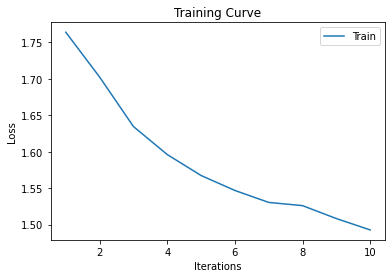

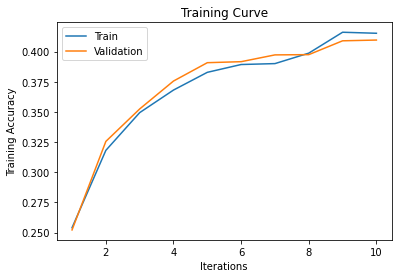

Final Training Accuracy: 0.41511960014280613
Final Validation Accuracy: 0.40949802124557383


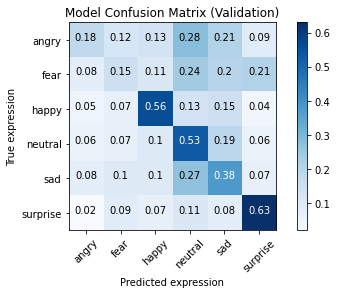

In [98]:
model1 = KLARR_NET()

if USE_CUDA:
    model1 = model1.cuda()

train(model1, train_data, valid_data, save=False)

Iteration 1: Train loss: 1.7223425148562952, Train accuracy: 0.30203498750446267 | Validation accuracy: 0.3003540928973131
Iteration 2: Train loss: 1.5822868489406325, Train accuracy: 0.3841038914673331 | Validation accuracy: 0.3695063528431577
Iteration 3: Train loss: 1.5058473314751277, Train accuracy: 0.41552124241342375 | Validation accuracy: 0.3905436367423453
Iteration 4: Train loss: 1.4586260555820032, Train accuracy: 0.3978489825062478 | Validation accuracy: 0.37887940012497395
Iteration 5: Train loss: 1.4258159900253469, Train accuracy: 0.43698679043198857 | Validation accuracy: 0.39387627577588
Iteration 6: Train loss: 1.4048968201333827, Train accuracy: 0.4428329168154231 | Validation accuracy: 0.40220787335971675
Iteration 7: Train loss: 1.3824876567179507, Train accuracy: 0.46429846483398785 | Validation accuracy: 0.41657987919183503
Iteration 8: Train loss: 1.363090792162852, Train accuracy: 0.4773741520885398 | Validation accuracy: 0.4174130389502187
Iteration 9: Train l

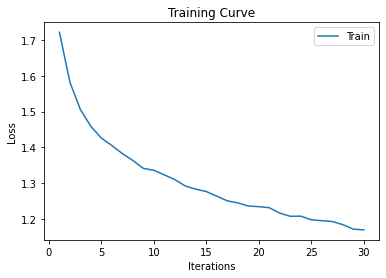

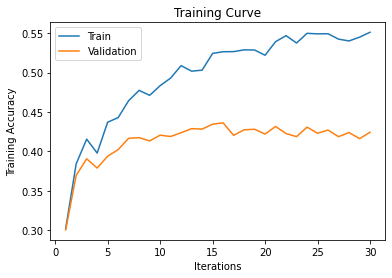

Final Training Accuracy: 0.5511424491253124
Final Validation Accuracy: 0.42428660695688397


In [9]:
model2 = KLARR_NET()

if USE_CUDA:
    model2 = model2.cuda()

train(
    model2,
    train_data,
    valid_data,
    learning_rate=0.005, 
    batch_size=128,
    iterations=30
)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class KLARR_NET2(nn.Module):
    def __init__(self):
        super(KLARR_NET2, self).__init__()
        self.name = 'KLARR_NET2'

        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 15, 5)
        self.conv2 = nn.Conv2d(15, 30, 3)
        self.conv3 = nn.Conv2d(30, 45, 2)

        self.fc1 = nn.Linear(4*4*45, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Linear layers
        x = x.view(-1, 4*4*45)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

Iteration 1: Train loss: 1.7427435842427341, Train accuracy: 0.3098446983220278 | Validation accuracy: 0.31680899812539054
Iteration 2: Train loss: 1.6246465254913678, Train accuracy: 0.3714298464833988 | Validation accuracy: 0.37304728181628827
Iteration 3: Train loss: 1.5491355508565903, Train accuracy: 0.3897715101749375 | Validation accuracy: 0.3807540095813372
Iteration 4: Train loss: 1.503993492234837, Train accuracy: 0.41369153873616565 | Validation accuracy: 0.4067902520308269
Iteration 5: Train loss: 1.4593353325670415, Train accuracy: 0.43283648696893967 | Validation accuracy: 0.4126223703395126
Iteration 6: Train loss: 1.4212926179170609, Train accuracy: 0.44189575151731525 | Validation accuracy: 0.4101228910643616
Iteration 7: Train loss: 1.3876413743604312, Train accuracy: 0.4612192074259193 | Validation accuracy: 0.42907727556759007
Iteration 8: Train loss: 1.3490434058687903, Train accuracy: 0.4840235630132096 | Validation accuracy: 0.44844823995001043
Iteration 9: Train

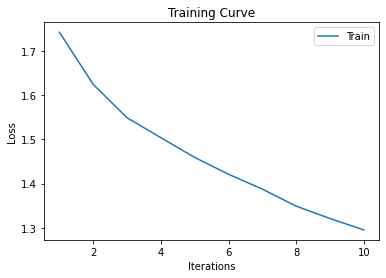

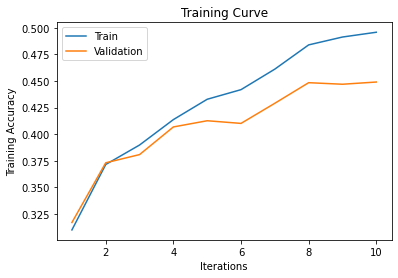

Final Training Accuracy: 0.4959389503748661
Final Validation Accuracy: 0.44907310976879816


In [19]:
model3 = KLARR_NET()

if USE_CUDA:
    model3 = model3.cuda()

train(
    model3,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=10
)

Iteration 1: Train loss: 1.7463106485930355, Train accuracy: 0.2814619778650482 | Validation accuracy: 0.2761924599041866
Iteration 2: Train loss: 1.6161862015724182, Train accuracy: 0.3453677258122099 | Validation accuracy: 0.3378462820245782
Iteration 3: Train loss: 1.5098857703534039, Train accuracy: 0.41721706533380937 | Validation accuracy: 0.4028327431785045
Iteration 4: Train loss: 1.4324277341365814, Train accuracy: 0.4602820421278115 | Validation accuracy: 0.4438658612789002
Iteration 5: Train loss: 1.360786345872012, Train accuracy: 0.4847822206354873 | Validation accuracy: 0.4574047073526349
Iteration 6: Train loss: 1.301879969510165, Train accuracy: 0.49723313102463407 | Validation accuracy: 0.4753176421578838
Iteration 7: Train loss: 1.2610304762016644, Train accuracy: 0.5181631560157087 | Validation accuracy: 0.4792751510102062
Iteration 8: Train loss: 1.2165822887962514, Train accuracy: 0.523741520885398 | Validation accuracy: 0.4732347427619246
Iteration 9: Train loss: 

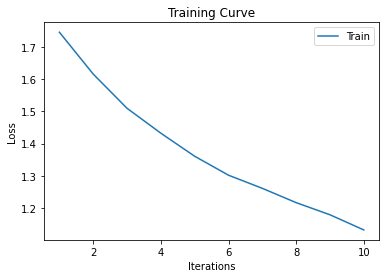

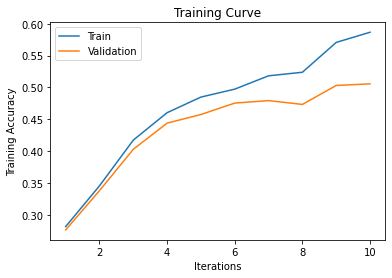

Final Training Accuracy: 0.5865762227775795
Final Validation Accuracy: 0.5055196833992918


In [22]:
model4 = KLARR_NET2()

if USE_CUDA:
    model4 = model4.cuda()

train(
    model4,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=10
)

Iteration 1: Train loss: 1.7326835271987049, Train accuracy: 0.2950285612281328 | Validation accuracy: 0.29285565507186
Iteration 2: Train loss: 1.6067990403283725, Train accuracy: 0.37187611567297396 | Validation accuracy: 0.37075609248073316
Iteration 3: Train loss: 1.5076359104026447, Train accuracy: 0.41369153873616565 | Validation accuracy: 0.3992918142053739
Iteration 4: Train loss: 1.4161930910565637, Train accuracy: 0.4609068189932167 | Validation accuracy: 0.44407415121849614
Iteration 5: Train loss: 1.3513638770038432, Train accuracy: 0.4899589432345591 | Validation accuracy: 0.47011039366798585
Iteration 6: Train loss: 1.2964925048026172, Train accuracy: 0.49669760799714385 | Validation accuracy: 0.46032076650697773
Iteration 7: Train loss: 1.2508661923083393, Train accuracy: 0.5218225633702249 | Validation accuracy: 0.4740679025203083
Iteration 8: Train loss: 1.2078768326477571, Train accuracy: 0.5549357372367012 | Validation accuracy: 0.49156425744636534
Iteration 9: Train

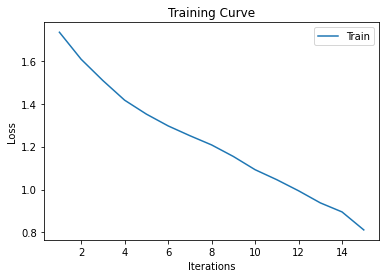

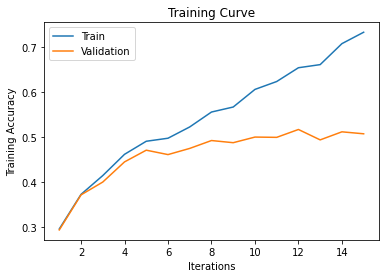

Final Training Accuracy: 0.732327740092824
Final Validation Accuracy: 0.5065611330972714


In [25]:
model5 = KLARR_NET2()

if USE_CUDA:
    model5 = model5.cuda()

train(
    model5,
    train_data,
    valid_data,
    learning_rate=0.003,
    batch_size=256,
    iterations=15
)

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class KLARR_NET3(nn.Module):
    def __init__(self):
        super(KLARR_NET3, self).__init__()
        self.name = 'KLARR_NET3'

        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 30, 4, padding=2)
        self.conv2 = nn.Conv2d(30, 60, 3, padding=2)
        self.conv3 = nn.Conv2d(60, 90, 2, padding=2)

        self.fc1 = nn.Linear(8*8*90, 125)
        self.fc2 = nn.Linear(125, 50)
        self.fc3 = nn.Linear(50, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Linear layers
        x = x.view(-1,8*8*90)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

Iteration 1: Train loss: 1.7608831524848938, Train accuracy: 0.2537486611924313 | Validation accuracy: 0.2582795250989377
Iteration 2: Train loss: 1.6437215493483976, Train accuracy: 0.3574616208496965 | Validation accuracy: 0.36054988544053324
Iteration 3: Train loss: 1.5234996188770642, Train accuracy: 0.4126651196001428 | Validation accuracy: 0.4076234117892106
Iteration 4: Train loss: 1.445495297962969, Train accuracy: 0.4476526240628347 | Validation accuracy: 0.43595084357425534
Iteration 5: Train loss: 1.3757207705215975, Train accuracy: 0.47576758300606925 | Validation accuracy: 0.45657154759425117
Iteration 6: Train loss: 1.3159835704348304, Train accuracy: 0.4684487682970368 | Validation accuracy: 0.4386586127890023
Iteration 7: Train loss: 1.2640165144746953, Train accuracy: 0.5259728668332738 | Validation accuracy: 0.4828160799833368
Iteration 8: Train loss: 1.2055820348587902, Train accuracy: 0.5411906461977865 | Validation accuracy: 0.48344094980212454
Iteration 9: Train l

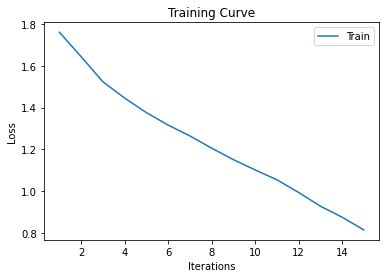

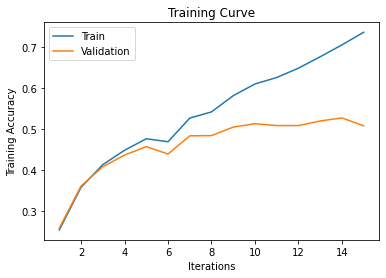

Final Training Accuracy: 0.7351392359871475
Final Validation Accuracy: 0.5071860029160592


In [30]:
model6 = KLARR_NET3()

if USE_CUDA:
    model6 = model6.cuda()

train(
    model6,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=15
)

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class KLARR_NET4(nn.Module):
    def __init__(self):
        super(KLARR_NET4, self).__init__()
        self.name = 'KLARR_NET4'

        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 30, 4, padding=2)
        self.conv2 = nn.Conv2d(30, 60, 3, padding=2)
        self.conv3 = nn.Conv2d(60, 90, 2, padding=2)

        self.fc1 = nn.Linear(8*8*90, 75)
        self.fc2 = nn.Linear(75, 20)
        self.fc3 = nn.Linear(20, 6)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Linear layers
        x = x.view(-1,8*8*90)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

Iteration 1: Train loss: 1.7458100413734263, Train accuracy: 0.29056586933238127 | Validation accuracy: 0.2959800041657988
Iteration 2: Train loss: 1.5878749760714443, Train accuracy: 0.3665208853980721 | Validation accuracy: 0.3667985836284107
Iteration 3: Train loss: 1.4779876985333182, Train accuracy: 0.4378793288111389 | Validation accuracy: 0.43011872526556966
Iteration 4: Train loss: 1.3810225278139114, Train accuracy: 0.46782399143163156 | Validation accuracy: 0.4526140387419288
Iteration 5: Train loss: 1.3169631375507875, Train accuracy: 0.5027668689753659 | Validation accuracy: 0.46844407415121847
Iteration 6: Train loss: 1.2580121538855813, Train accuracy: 0.5234291324526955 | Validation accuracy: 0.4753176421578838
Iteration 7: Train loss: 1.2016162032430822, Train accuracy: 0.5620760442699037 | Validation accuracy: 0.502603624244949
Iteration 8: Train loss: 1.1484487449580973, Train accuracy: 0.5858175651553017 | Validation accuracy: 0.5092689023120184
Iteration 9: Train lo

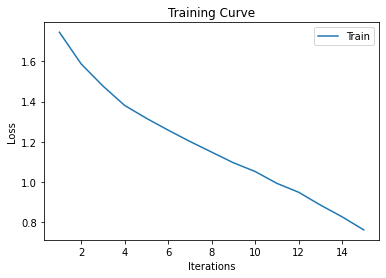

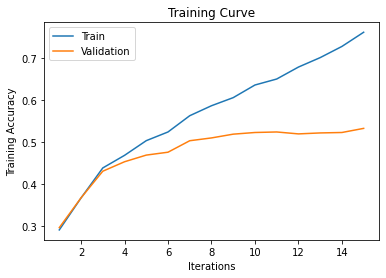

Final Training Accuracy: 0.7605319528739736
Final Validation Accuracy: 0.5319725057279734


In [33]:
model7 = KLARR_NET3()

if USE_CUDA:
    model7 = model7.cuda()

train(
    model7,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=15
)

Iteration 1: Train loss: 1.756231740117073, Train accuracy: 0.2620938950374866 | Validation accuracy: 0.26452822328681524
Iteration 2: Train loss: 1.6378280479799618, Train accuracy: 0.3624152088539807 | Validation accuracy: 0.35617579670901894
Iteration 3: Train loss: 1.5200906721028415, Train accuracy: 0.4014637629418065 | Validation accuracy: 0.386377837950427
Iteration 4: Train loss: 1.446846840056506, Train accuracy: 0.44113709389503747 | Validation accuracy: 0.42053738804415747
Iteration 5: Train loss: 1.3887532217936083, Train accuracy: 0.4615762227775794 | Validation accuracy: 0.43324307435950843
Iteration 6: Train loss: 1.3352781290357763, Train accuracy: 0.4796947518743306 | Validation accuracy: 0.4532389085607165
Iteration 7: Train loss: 1.2940467948263341, Train accuracy: 0.5102641913602285 | Validation accuracy: 0.47115184336596544
Iteration 8: Train loss: 1.2564122554930774, Train accuracy: 0.5207515173152446 | Validation accuracy: 0.4774005415538429
Iteration 9: Train lo

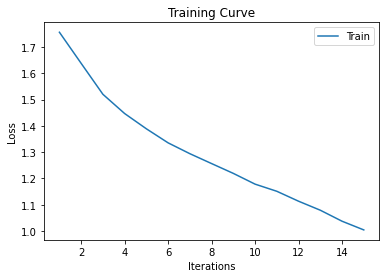

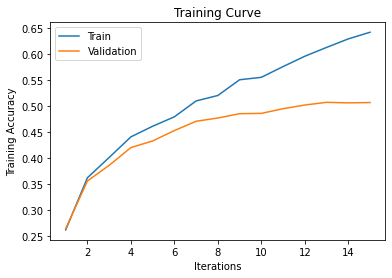

Final Training Accuracy: 0.6424491253123884
Final Validation Accuracy: 0.5071860029160592


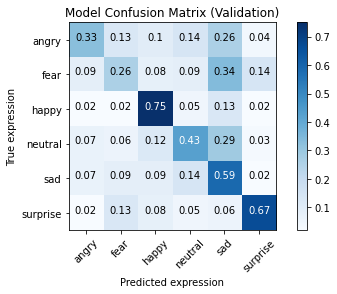

In [100]:
model8 = KLARR_NET4()

if USE_CUDA:
    model8 = model8.cuda()

train(
    model8,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=15
)

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class KLARR_NET5(nn.Module):
    def __init__(self):
        super(KLARR_NET5, self).__init__()
        self.name = 'KLARR_NET5'

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc_input = 4*4*256

        self.fc = nn.Sequential(
            nn.Linear(self.fc_input, 75),
            nn.ReLU(),

            nn.Linear(75, 20),
            nn.ReLU(),

            nn.Linear(20, 6)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x.view(-1, self.fc_input))
        return x

Iteration 1: Train loss: 1.758128743280064, Train accuracy: 0.27842734737593716 | Validation accuracy: 0.2809831285148927
Iteration 2: Train loss: 1.6463557237928563, Train accuracy: 0.3384951802927526 | Validation accuracy: 0.3328473234742762
Iteration 3: Train loss: 1.5450438491322778, Train accuracy: 0.39954480542663334 | Validation accuracy: 0.3899187669235576
Iteration 4: Train loss: 1.4710337871854955, Train accuracy: 0.4264102106390575 | Validation accuracy: 0.4030410331181004
Iteration 5: Train loss: 1.3997942385348408, Train accuracy: 0.46166547661549445 | Validation accuracy: 0.4411580920641533
Iteration 6: Train loss: 1.3410769010132009, Train accuracy: 0.472197429489468 | Validation accuracy: 0.446990210372839
Iteration 7: Train loss: 1.2946524890986355, Train accuracy: 0.5033916458407711 | Validation accuracy: 0.46636117475525934
Iteration 8: Train loss: 1.2519530721686103, Train accuracy: 0.5162441985005355 | Validation accuracy: 0.474692772339096
Iteration 9: Train loss:

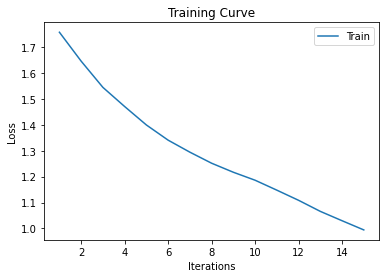

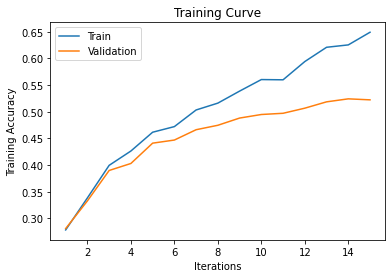

Final Training Accuracy: 0.6491877900749732
Final Validation Accuracy: 0.5223911685065611


In [39]:
model9 = KLARR_NET5()

if USE_CUDA:
    model9 = model9.cuda()

train(
    model9,
    train_data,
    valid_data,
    learning_rate=0.002,
    batch_size=256,
    iterations=15
)